In [1242]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [1243]:
MAX_N_SAMPLES = {
    "cascifw": 200,
    "fayoum": 175
}

REPLACE_DICT = {
    "vgg": "VGG",
    "resnet": "ResNet-",
    "densenet": "DenseNet",
    "alexnet": "AlexNet",
    "squeezenet": "SqueezeNet",
    "all": "Full model",
    "clf": "Classifier only",
    "fc": "Classifier only",
    "model": "Model"
}

def replace_substrings(df: pd.DataFrame):
    for col in df.columns:
        for k, v in REPLACE_DICT.items():
            df[col] = df[col].str.replace(k, v)
    cols_to_rename = {k: v for k, v in REPLACE_DICT.items() if k in df.columns}
    df.rename(columns=cols_to_rename, inplace=True)
    return df

In [1244]:
def get_baseline_results(dataset):
    assert dataset in ["cascifw", "cascifw_reduced", "fayoum", "fayoum_reduced"]
    cnn_results = pd.read_csv(f"results/wandb_export_{dataset}.csv")
       
    if dataset.endswith("_reduced"):
        dataset = dataset[:-8]
    cnn_results.dropna(subset=["test_accuracy"], inplace=True)  # remove invalid runs
    cnn_results = cnn_results[cnn_results["mode"] != "finetune"]
    if "n_train_samples" in cnn_results.columns:
        cnn_results["n_train_samples"].replace(-1, MAX_N_SAMPLES[dataset], inplace=True)
    else:
        cnn_results["n_train_samples"] = MAX_N_SAMPLES[dataset]

    cnn_grouped = pd.DataFrame()
    cnn_grouped["test_acc_mean"] = cnn_results.groupby(["model", "mode", "n_train_samples"])["test_accuracy"].mean()
    cnn_grouped["test_acc_std"] = cnn_results.groupby(["model", "mode", "n_train_samples"])["test_accuracy"].std()
    cnn_grouped.sort_values("test_acc_mean", inplace=True, ascending=False)
    cnn_grouped.reset_index(inplace=True)
    return cnn_results, cnn_grouped

In [1245]:
def create_cnn_table():
    def create_cnn_table_dataset(dataset):
        _, cnn_grouped = get_baseline_results(dataset)
            # 检查 'mode' 列是否存在于 DataFrame 中
        '''
        if 'mode' in cnn_grouped.columns:
            unique_modes = cnn_grouped['mode'].unique()
            print("Unique values in 'mode' column:", unique_modes)
        else:
            print("'mode' column is not present in the DataFrame.")
            '''
        subset = cnn_grouped[cnn_grouped["n_train_samples"] == MAX_N_SAMPLES[dataset]].reset_index()
        '''
        if 'mode' in subset.columns:
            unique_modes = subset['mode'].unique()
            print("Unique values in 'mode' column:", unique_modes)
        else:
            print("'mode' column is not present in the DataFrame.")
            '''
        #print(subset.columns)
        #print(subset['mode'].head())
        # 使用 .unique() 方法查看 'mode' 列中的唯一值
        #unique_modes = subset['mode'].unique()
        
        # 打印结果
        #print("Unique values in 'mode' column:", unique_modes)
        df = pd.DataFrame()
        df["model"] = subset["model"]
        df["trained"] = subset["mode"]
        df["test_accuracy"] = subset.apply(lambda x : f'{x["test_acc_mean"]:.3f} \u00B1 {x["test_acc_std"]:.3f}', axis = 1)
        #print(df['trained'].unique())

        latex_table = df.pivot(index="model", columns="trained", values="test_accuracy").reset_index().sort_values(by="all", ascending=False)
        latex_table = replace_substrings(latex_table)
        latex_table.columns.name = None
        return latex_table
    cascifw = create_cnn_table_dataset("cascifw").set_index("Model")
    fayoum = create_cnn_table_dataset("fayoum").set_index("Model")
    
    cascifw.columns = pd.MultiIndex.from_arrays([["CASC IFW"] * 2,cascifw.columns])
    fayoum.columns = pd.MultiIndex.from_arrays([["Fayoum Banana"] * 2,fayoum.columns])
    print(cascifw.sort_index().to_latex())
    print(fayoum.sort_index().to_latex())
    #return fayoum.join(cascifw).sort_index()
    #return cascifw.sort_index()

In [1246]:
#print(create_cnn_table().to_latex())
create_cnn_table()

\begin{tabular}{lll}
\toprule
 & \multicolumn{2}{r}{CASC IFW} \\
 & Full model & Classifier only \\
Model &  &  \\
\midrule
SqueezeNet & 1.000 ± nan & 1.000 ± nan \\
VGG & 0.988 ± nan & 0.988 ± nan \\
\bottomrule
\end{tabular}

\begin{tabular}{lll}
\toprule
 & \multicolumn{2}{r}{Fayoum Banana} \\
 & Full model & Classifier only \\
Model &  &  \\
\midrule
AlexNet & 0.883 ± 0.030 & 0.864 ± 0.016 \\
ResNet-50 & 0.902 ± 0.030 & 0.883 ± 0.040 \\
\bottomrule
\end{tabular}



In [1247]:

shallow_results_cascifw = pd.read_csv("results/exp_01_cascifw.txt", delimiter=";").drop(columns=["train_samples", "val_samples", "test_samples"])
shallow_results_cascifw["dataset"] = "cascifw"
shallow_results_fayoum = pd.read_csv("results/exp_01_fayoum.txt", delimiter=";").drop(columns=["train_samples", "val_samples", "test_samples"])
shallow_results_fayoum["dataset"] = "fayoum"
shallow_results = pd.concat([shallow_results_cascifw, shallow_results_fayoum])


In [1248]:
df = pd.DataFrame()
#df.dtypes
# 确保 test_acc 列是数值类型
shallow_results['test_acc'] = pd.to_numeric(shallow_results['test_acc'], errors='coerce')
# 从DataFrame中移除任何包含NaN的'test_acc'行
shallow_results = shallow_results[shallow_results['test_acc'].notna()]
df["test_acc_mean"] = shallow_results.groupby(["dataset", "transformer", "model"])["test_acc"].mean()
df["test_acc_std"] = shallow_results.groupby(["dataset", "transformer", "model"])["test_acc"].std()
df["best_params"] = shallow_results.groupby(["dataset", "transformer", "model"])["best_params"].first()
df.reset_index(inplace=True)
df.sort_values("test_acc_mean", inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)

df["test_acc"] = df.apply(lambda x : f'{x["test_acc_mean"]:.3f} \u00B1 {x["test_acc_std"]:.3f}', axis = 1)

df = df[["dataset", "transformer", "model", "test_acc", "best_params"]].rename(columns={"model":"classifier"}).set_index(["transformer", "classifier"])

In [1249]:
df[df["dataset"] == "cascifw"]

dataset       test_acc  \
transformer classifier                                       
dino_vitb8  KNeighborsClassifier    cascifw  1.000 ± 0.000   
dino_vits8  SVC                     cascifw  1.000 ± 0.000   
dino_vitb8  MLPClassifier           cascifw  1.000 ± 0.000   
            SVC                     cascifw  1.000 ± 0.000   
            LogisticRegression      cascifw  1.000 ± 0.000   
dino_vits8  LogisticRegression      cascifw  1.000 ± 0.000   
            MLPClassifier           cascifw  1.000 ± 0.000   
            RandomForestClassifier  cascifw  1.000 ± 0.000   
dino_vitb8  RandomForestClassifier  cascifw  0.997 ± 0.006   
dino_vits8  KNeighborsClassifier    cascifw  0.993 ± 0.007   
dino_vitb8  XGBClassifier           cascifw  0.978 ± 0.006   
dino_vits8  XGBClassifier           cascifw  0.975 ± 0.029   

                                                                          best_params  
transformer classifier                                                                 
dino_vitb8  KNeighborsClassifier             {'n_neighbors': 3, 'weights': 'uniform'}  
dino_vits8  SVC                            {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}  
dino_vitb8  MLPClassifier           {'activation': 'tanh', 'alpha': 0.0001, 'hidde...  
            SVC                             {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}  
            LogisticRegression                                               {'C': 1}  
dino_vits8  LogisticRegression                                               {'C': 1}  
            MLPClassifier           {'activation': 'tanh', 'alpha': 0.0001, 'hidde...  
            RandomForestClassifier                              {'n_estimators': 500}  
dino_vitb8  RandomForestClassifier                              {'n_estimators': 100}  
dino_vits8  KNeighborsClassifier             {'n_neighbors': 3, 'weights': 'uniform'}  
dino_vitb8  XGBClassifier                                       {'n_estimators': 100}  
dino_vits8  XGBClassifier                                       {'n_estimators': 100}

In [1250]:
df[df["dataset"] == "fayoum"]

dataset       test_acc  \
transformer classifier                                      
dino_vitb8  KNeighborsClassifier    fayoum  0.981 ± 0.000   
            MLPClassifier           fayoum  0.967 ± 0.008   
            SVC                     fayoum  0.963 ± 0.012   
dino_vits8  KNeighborsClassifier    fayoum  0.960 ± 0.023   
dino_vitb8  LogisticRegression      fayoum  0.952 ± 0.010   
            RandomForestClassifier  fayoum  0.952 ± 0.023   
dino_vits8  SVC                     fayoum  0.950 ± 0.021   
dino_vitb8  XGBClassifier           fayoum  0.944 ± 0.000   
dino_vits8  MLPClassifier           fayoum  0.944 ± 0.012   
            RandomForestClassifier  fayoum  0.928 ± 0.017   
            LogisticRegression      fayoum  0.926 ± 0.012   
            XGBClassifier           fayoum  0.918 ± 0.009   

                                                                          best_params  
transformer classifier                                                                 
dino_vitb8  KNeighborsClassifier            {'n_neighbors': 3, 'weights': 'distance'}  
            MLPClassifier           {'activation': 'tanh', 'alpha': 0.0001, 'hidde...  
            SVC                          {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}  
dino_vits8  KNeighborsClassifier            {'n_neighbors': 5, 'weights': 'distance'}  
dino_vitb8  LogisticRegression                                               {'C': 1}  
            RandomForestClassifier                               {'n_estimators': 10}  
dino_vits8  SVC                             {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}  
dino_vitb8  XGBClassifier                                       {'n_estimators': 100}  
dino_vits8  MLPClassifier           {'activation': 'tanh', 'alpha': 0.0001, 'hidde...  
            RandomForestClassifier                               {'n_estimators': 10}  
            LogisticRegression                                               {'C': 1}  
            XGBClassifier                                       {'n_estimators': 100}

In [1251]:
# 初始df中"fayoum"数据集的行数
#print("Initial 'fayoum' row column:", df[df["dataset"] == "fayoum"].shape[1])
#print("Initial 'cascifw' row column:", df[df["dataset"] == "cascifw"].shape[1])
ltx_fayoum = df[df["dataset"] == "fayoum"].reset_index().drop(columns=["dataset", "best_params"])
#print("Row column after filtering and dropping 'fayoum':", ltx_fayoum.shape[1])
ltx_cascifw = df[df["dataset"] == "cascifw"].reset_index().drop(columns=["dataset", "best_params"])
#print("Row column after filtering and dropping 'cascifw':", ltx_cascifw.shape[1])
ltx_fayoum = ltx_fayoum.pivot(index="classifier", columns="transformer", values="test_acc").sort_index()
#print("Row column after pivoting 'fayoum':", ltx_fayoum.shape[1])
ltx_cascifw = ltx_cascifw.pivot(index="classifier", columns="transformer", values="test_acc").sort_index()
#print("Row column after pivoting 'cascifw':", ltx_cascifw.shape[1])

ltx_fayoum.columns = pd.MultiIndex.from_arrays([["Fayoum Banana"] * 2,ltx_fayoum.columns])
ltx_cascifw.columns = pd.MultiIndex.from_arrays([["CASC IFW"] * 2,ltx_cascifw.columns])

In [1252]:
print(ltx_fayoum.join(ltx_cascifw).to_latex())

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{Fayoum Banana} & \multicolumn{2}{r}{CASC IFW} \\
transformer & dino_vitb8 & dino_vits8 & dino_vitb8 & dino_vits8 \\
classifier &  &  &  &  \\
\midrule
KNeighborsClassifier & 0.981 ± 0.000 & 0.960 ± 0.023 & 1.000 ± 0.000 & 0.993 ± 0.007 \\
LogisticRegression & 0.952 ± 0.010 & 0.926 ± 0.012 & 1.000 ± 0.000 & 1.000 ± 0.000 \\
MLPClassifier & 0.967 ± 0.008 & 0.944 ± 0.012 & 1.000 ± 0.000 & 1.000 ± 0.000 \\
RandomForestClassifier & 0.952 ± 0.023 & 0.928 ± 0.017 & 0.997 ± 0.006 & 1.000 ± 0.000 \\
SVC & 0.963 ± 0.012 & 0.950 ± 0.021 & 1.000 ± 0.000 & 1.000 ± 0.000 \\
XGBClassifier & 0.944 ± 0.000 & 0.918 ± 0.009 & 0.978 ± 0.006 & 0.975 ± 0.029 \\
\bottomrule
\end{tabular}



In [1253]:
def read_single(file):
    df_e03_grouped = pd.read_csv(file, delimiter=";")
    #df.dtypes
    # 确保 test_acc 列是数值类型
    df_e03_grouped['test_acc'] = pd.to_numeric(df_e03_grouped['test_acc'], errors='coerce')
    # 从DataFrame中移除任何包含NaN的'test_acc'行
    df_e03_grouped = df_e03_grouped[df_e03_grouped['test_acc'].notna()]
    df_e03_grouped = df_e03_grouped.dropna(subset=['test_acc'])
    
    # 按 'encoder' 分组并计算所需的统计数据
    df_e03_grouped = df_e03_grouped.groupby('encoder')['test_acc']
    df = pd.DataFrame()
    df["test_acc_mean"] = df_e03_grouped.mean()
    df["test_acc_std"] = df_e03_grouped.std()
    df["test_acc"] = df.apply(lambda x : f'{x["test_acc_mean"]:.3f} \u00B1 {x["test_acc_std"]:.3f}', axis = 1)
    #df.sort_values("test_acc_mean", ascending=False)[["test_acc"]]
    return df[["test_acc"]].sort_index()

e03_fayoum = read_single("results/exp_03_fayoum.txt")
e03_fayoum.columns = pd.MultiIndex.from_arrays([["Fayoum Banana"] * 1,e03_fayoum.columns])
e03_cascifw = read_single("results/exp_03_cascifw.txt")
e03_cascifw.columns = pd.MultiIndex.from_arrays([["CASC IFW"] * 1,e03_cascifw.columns])
print(e03_fayoum.join(e03_cascifw).to_latex())

\begin{tabular}{lll}
\toprule
 & Fayoum Banana & CASC IFW \\
 & test_acc & test_acc \\
encoder &  &  \\
\midrule
dino_resnet50 & 0.937 ± 0.010 & 0.975 ± 0.015 \\
dino_vitb16 & 0.937 ± 0.016 & 0.957 ± 0.007 \\
dino_vitb8 & 0.944 ± 0.000 & 0.978 ± 0.006 \\
dino_vits16 & 0.944 ± 0.012 & 0.982 ± 0.007 \\
dino_vits8 & 0.919 ± 0.010 & 0.975 ± 0.029 \\
resnet101 & 0.959 ± 0.008 & 0.972 ± 0.014 \\
resnet152 & 0.941 ± 0.023 & 0.965 ± 0.016 \\
resnet18 & 0.948 ± 0.015 & 0.985 ± 0.016 \\
resnet50 & 0.937 ± 0.020 & 0.960 ± 0.019 \\
vgg & 0.889 ± 0.017 & 0.985 ± 0.016 \\
\bottomrule
\end{tabular}



In [1254]:
baselines = {
    "cascifw": ["vgg", "squeezenet"],
    "fayoum": [
        "alexnet",
        #"vgg", 
        "resnet50"
        #"squeezenet"
    ]
            }
shallow_results_file = {
    "cascifw": "results/exp_01_cascifw.txt",
    "fayoum": "results/exp_01_fayoum.txt"
}
shallow_results_file2 = {
    "cascifw": "results/exp_02_cascifw.txt",
    "fayoum": "results/exp_02_fayoum.txt"
}
shallow_model = {
    "cascifw": ("dino_vitb8", "XGBoost"),
    "fayoum": ("dino_vits8", "XGBoost")
}

def get_reduced_df(dataset):
    cols = ["model", "mode", "n_train_samples", "test_accuracy"]
    cascifw_reduced, _ = get_baseline_results(f"{dataset}")
    if dataset == "cascifw":
        cascifw, _ = get_baseline_results(dataset)
        cnn_baseline = pd.concat([cascifw[cols], cascifw_reduced[cols]])
    else:
        cnn_baseline = cascifw_reduced[cols]

    cnn_baseline = cnn_baseline[cnn_baseline["model"].isin(baselines[dataset])]
    unique_models0 = cnn_baseline['model'].unique()
    #print("Unique model values:", unique_models0)   
    cnn_baseline["model"] = cnn_baseline.apply(lambda x: f"{x['model']}, {x['mode']}", axis=1)
    cnn_baseline.drop(columns=["mode"], inplace=True)

    shallow_results = pd.read_csv(shallow_results_file[dataset], delimiter=";")
    dino_vits = shallow_results.loc[(shallow_results["model"] == shallow_model[dataset][1]) & (shallow_results["transformer"] == shallow_model[dataset][0]),:]
    # 创建一个副本来避免 SettingWithCopyWarning
    dino_vits = shallow_results.loc[(shallow_results["model"] == shallow_model[dataset][1]) & (shallow_results["transformer"] == shallow_model[dataset][0])].copy()

    dino_vits.rename(columns={"train_samples": "n_train_samples", "test_acc": "test_accuracy"}, inplace=True)
    dino_vits.loc[:, "model"] = shallow_model[dataset][0] + " + " + shallow_model[dataset][1]
    dino_vits.loc[:, "n_train_samples"] = MAX_N_SAMPLES[dataset]

    dino_vits = dino_vits[["model", "n_train_samples", "test_accuracy"]]

    dino_vits_2 = pd.read_csv(shallow_results_file2[dataset], delimiter=";")
    dino_vits_2.rename(columns={"train_samples": "n_train_samples", "test_acc": "test_accuracy"}, inplace=True)
    dino_vits_2.loc[:, "model"] = shallow_model[dataset][0] + " + " + shallow_model[dataset][1]
    dino_vits_2 = dino_vits_2[["model", "n_train_samples", "test_accuracy"]]

    #df = pd.concat([dino_vits, dino_vits_2, cnn_baseline]).reset_index(drop=True)
    df = pd.concat([ dino_vits_2, cnn_baseline]).reset_index(drop=True)
    return df


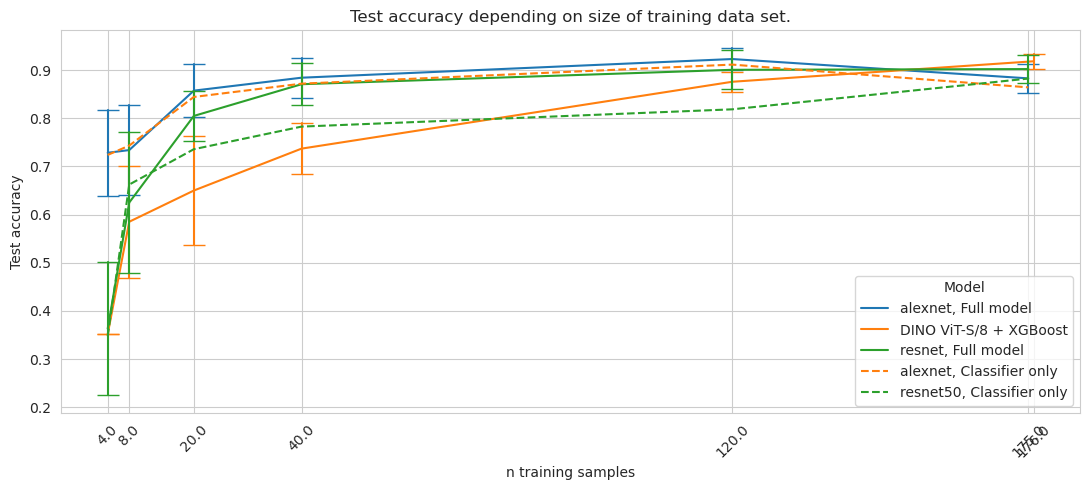

In [1255]:
df = get_reduced_df("fayoum")
df["n_train_samples"].replace({176:175}, inplace=True)
# 打印 model 列中的所有唯一值
unique_models = df['model'].unique()
#print("Unique model values:", unique_models)
df.sort_values("model", inplace=True)
# 打印 model 列中的所有唯一值
unique_models = df['model'].unique()
#print("Unique model values:", unique_models)
df["model"] = df["model"].map({"dino_vits8 + XGBoost": "DINO ViT-S/8 + XGBoost",
           "vgg, all": "VGG, Full model",
                  "vgg, clf": "VGG, Classifier only",
                  "squeezenet, all": "SqueezeNet, Full model",
                  "squeezenet, clf": "SqueezeNet, Classifier only",
                  "alexnet, clf":"alexnet, Classifier only",
                  "resnet50, clf":"resnet50, Classifier only",
                  "alexnet, all":"alexnet, Full model",
                  "resnet50, all":"resnet, Full model",
                               })
# 打印 model 列中的所有唯一值
unique_models = df['model'].unique()
#print("Unique model values:", unique_models)

sns.set_style("whitegrid")
# 将所有数据尝试转换为数值类型
df['n_train_samples'] = pd.to_numeric(df['n_train_samples'], errors='coerce')

df.dropna(subset=['n_train_samples'], inplace=True)
   

#print(df['n_train_samples'].apply(type).unique())

x_lbls = np.unique(df["n_train_samples"].values)
fig, ax = plt.subplots(figsize=(11,5))


#g = sns.lineplot(data=df[~df["model"].str.endswith("only")], x="n_train_samples", y="test_accuracy", palette=["C0", "C1", "C2"],  ci='sd', err_style='bars', hue="model", err_kws={'capsize':8})
g = sns.lineplot(data=df[~df["model"].str.endswith("only")], x="n_train_samples", y="test_accuracy", palette=["C0", "C1", "C2"], errorbar='sd', err_style='bars', hue="model", err_kws={'capsize':8})

clf_only = df[df["model"].str.endswith("only")]
clf_only = clf_only.groupby(["model", "n_train_samples"]).mean().reset_index()
# 打印 model 列中的所有唯一值
unique_models1 = clf_only['model'].unique()
#print("Unique model values:", unique_models1)

sns.lineplot(data=clf_only, x="n_train_samples", y="test_accuracy", hue="model", palette=["C1", "C2"], linestyle="--")
# 确保 clf_only 数据集中确实包含 `model` 列作为 `hue` 参数
g.set_xticks(x_lbls)
g.set_xticklabels(labels=x_lbls, rotation=45)
leg = ax.legend()
leg.set_title("Model")
leg_lines = leg.get_lines()
leg_lines[3].set_linestyle("--")
leg_lines[4].set_linestyle("--")
ax.invert_yaxis()
ax.set(xlabel="n training samples", ylabel = "Test accuracy")
plt.title("Test accuracy depending on size of training data set.")
plt.tight_layout()
plt.savefig("figures/acc_by_samples_fayoum.pdf")
plt.show()

In [1256]:
SAVE = True
FIGSIZE = (11, 8)
LABELS = {
    #"cascifw": ["Healthy", "Damaged"],
    "fayoum": ["Green", "Yellowish_Green", "Midripen", "Overripen"]
}

COLORS = {
    "fayoum": ["#b5e61d", "#ffc90e", "#b97957", "#7f7f7f"]
}

In [1257]:
labels = {#"cascifw": {"condition": np.load("results/dim_reduction/cascifw/labels_cascifw.npy")},
          "fayoum": {"ripeness": np.load("results/dim_reduction/fayoum/labels_fayoum.npy")}
         }

def build_dataframe(dataset, embed_suffix="_embed.npy"):
    df = pd.DataFrame()
    for label in labels[dataset]:
        df[label] = labels[dataset][label]
        
    for file in os.listdir(f"results/dim_reduction/{dataset}"):
        if not file.startswith(dataset):
            continue
        embed_name = file[len(dataset)+1:-len(embed_suffix)]
        embeds = np.load(f"results/dim_reduction/{dataset}/{file}")
        
        #print(f"Shape of loaded embeddings: {embeds.shape}")
        if embeds.ndim == 1:  # 如果是一维数组
            df[f"{embed_name}_0"] = embeds[0] if len(embeds) > 0 else np.nan  # 检查是否有足够的元素
            df[f"{embed_name}_1"] = embeds[1] if len(embeds) > 1 else np.nan  # 检查是否有足够的元素
        elif embeds.ndim > 1:
            df[f"{embed_name}_0"] = embeds[:, 0]
            df[f"{embed_name}_1"] = embeds[:, 1]
        #df[f"{embed_name}_0"] = embeds[:, 0]
        #df[f"{embed_name}_1"] = embeds[:, 1]
    return df

#df_cascifw = build_dataframe("cascifw")
df_fayoum = build_dataframe("fayoum")

In [1258]:
def subplots(method, dataset, n_dims=2, y_labels=None, title=None, kde=True, scatter=True, kdefill=True, figsize=FIGSIZE, save=SAVE, **plt_kwargs):
    data = eval(f"df_{dataset}")
    assert n_dims in [1, 2]
        
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    for i, embed in enumerate(["resnet50", "vgg", "dino_vits8", "dino_vitb8"]):
        j1 = int(i>1)
        j2 = i%2
        if n_dims == 1:
            sns.histplot(ax=axes[j1][j2], data=data, x=f"{embed}_{method}_0" ,hue="condition", alpha=0.5, stat="density", common_norm=False, element="step", palette=COLORS.get(dataset))
        else:
            if kde:
                sns.kdeplot(ax=axes[j1][j2], x=f"{embed}_{method}_0", y=f"{embed}_{method}_1", hue=y_labels, data=data, fill=kdefill, palette=COLORS.get(dataset), alpha=.5, **plt_kwargs)
            if scatter:
                sns.scatterplot(ax=axes[j1][j2], x=f"{embed}_{method}_0", y=f"{embed}_{method}_1", hue=y_labels, data=data, palette=COLORS.get(dataset), **plt_kwargs)
        axes[j1][j2].set_title(f"{embed} embeddings")
        axes[j1][j2].set(xlabel=f'{method} component 0', ylabel=f'{method} component 1' if n_dims==2 else "density")
    if title:
        fig.suptitle(title)
    else:
        fig.suptitle(method)
    
    handles = axes[0][0].get_legend().legend_handles

    fig.legend(handles, LABELS[dataset], loc='upper right')
    for j1 in [0, 1]:
        for j2 in [0, 1]:
            axes[j1][j2].get_legend().remove()
    plt.tight_layout()
    
    if save:
        # 检查目录是否存在，如果不存在则创建
        save_path = 'figures'
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # 现在保存文件的代码行可以正常工作
        plt.savefig(f"{save_path}/dim_reduction_{dataset}_{method}_{figsize[0]}x{figsize[1]}.pdf")

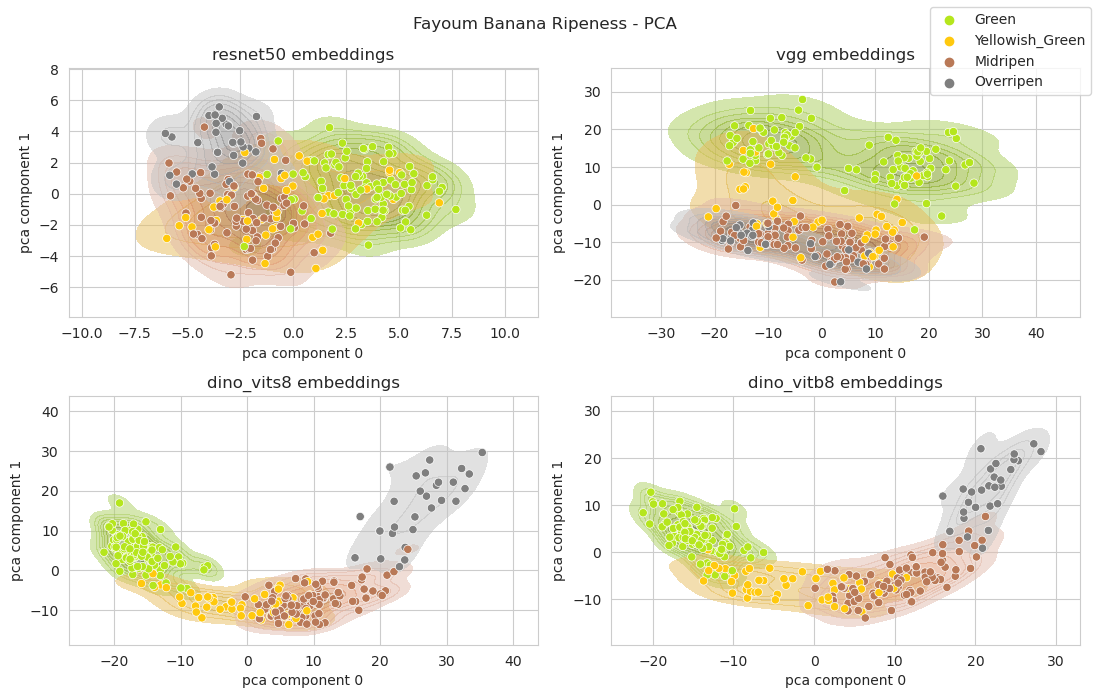

In [1259]:
subplots("pca", "fayoum", y_labels="ripeness", title="Fayoum Banana Ripeness - PCA", figsize=(11, 7))

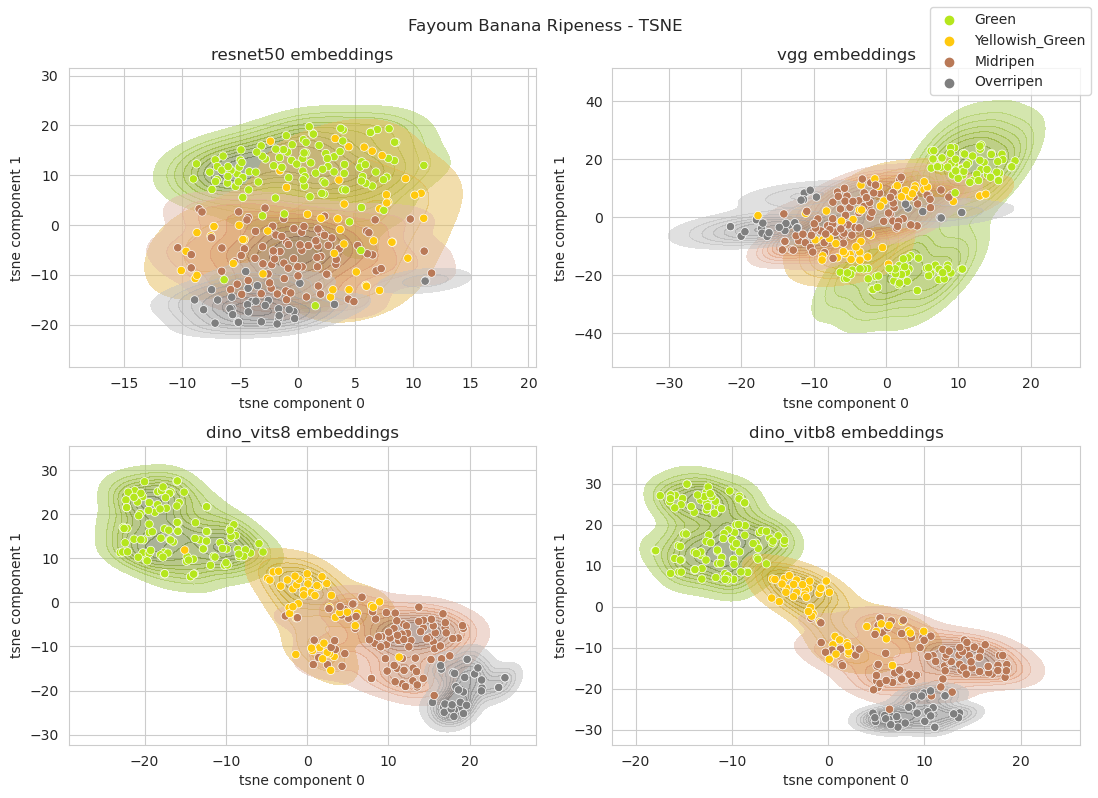

In [1260]:
subplots("tsne", "fayoum", y_labels="ripeness", title="Fayoum Banana Ripeness - TSNE")

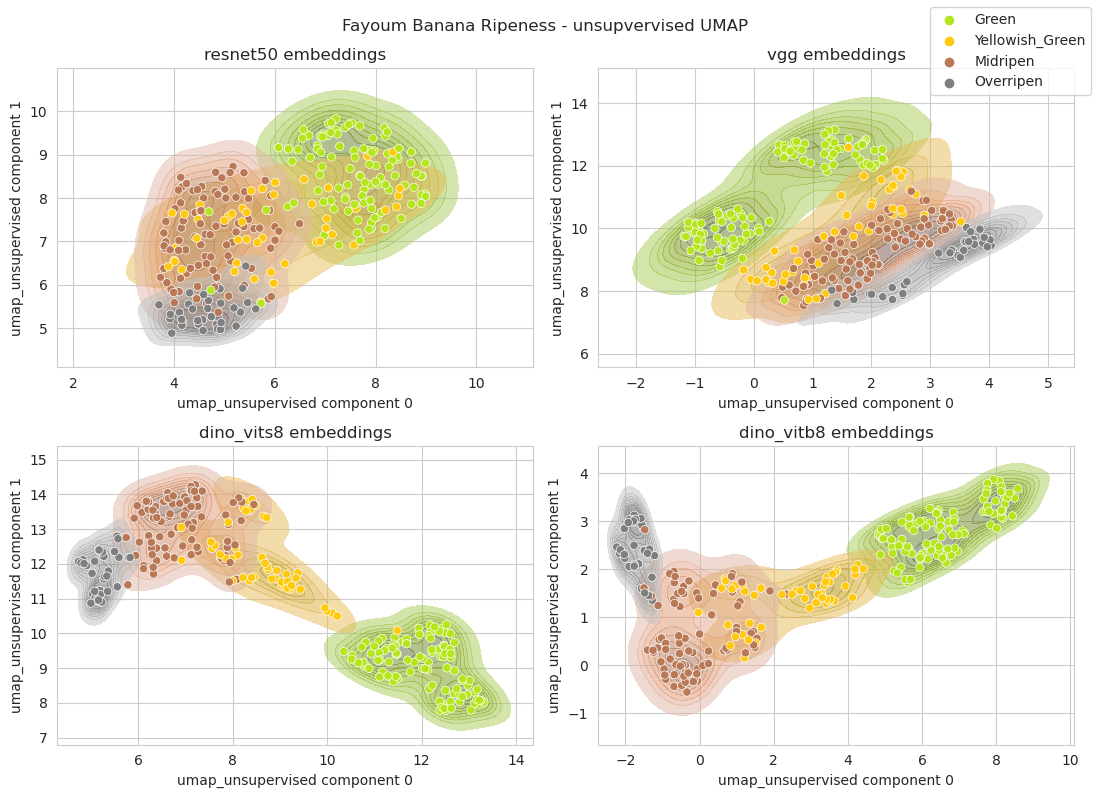

In [1261]:
subplots("umap_unsupervised", "fayoum", y_labels="ripeness", title="Fayoum Banana Ripeness - unsupvervised UMAP")

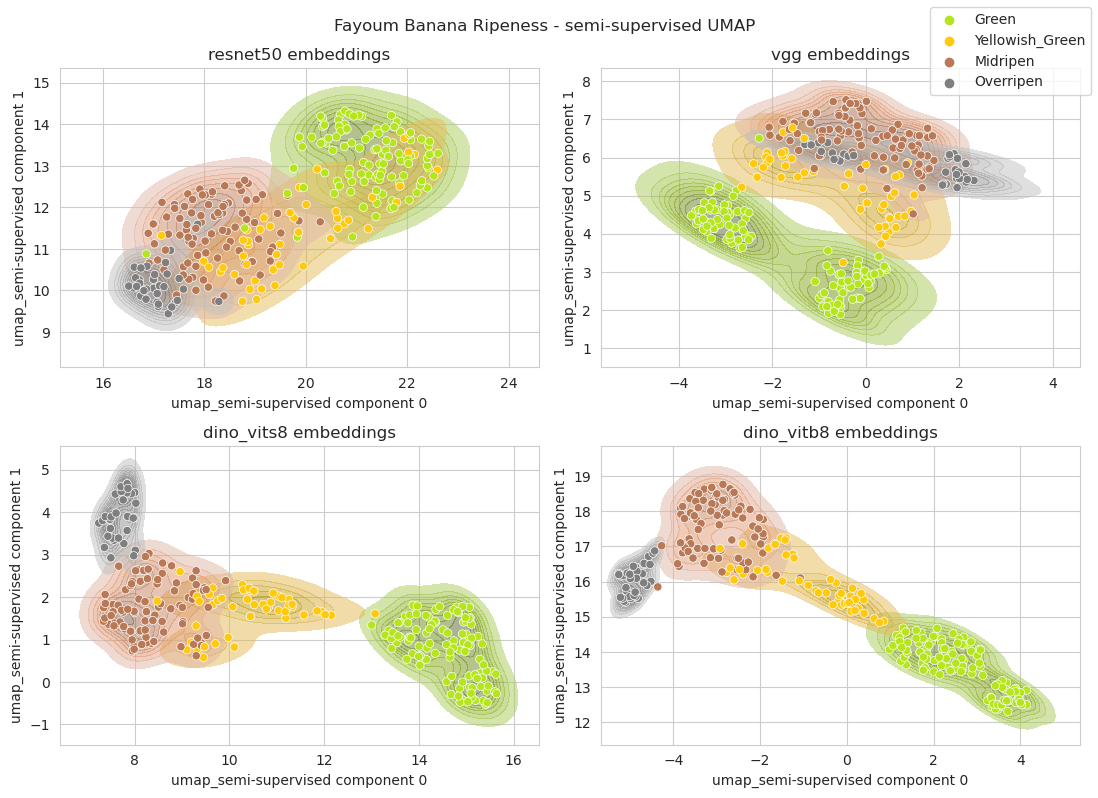

In [1262]:
subplots("umap_semi-supervised", "fayoum", y_labels="ripeness", title="Fayoum Banana Ripeness - semi-supervised UMAP")